# Table of contents
1. [Problem Description](#problem-description)
2. [Exploratory Data Analysis](#exp-data-analysis)
    1. [Ranges of values, data types & missing values](#ranges)
    2. [Feature Importance - Difference and Risk Ratios](#risk-ratio)
    3. [Setup validation Network](#val-net)
    4. [One hot encoding](#one-hot)
    5. [Feature Importance: Mutual Information](#mutual-info)
    6. [Feature Importance: Correlation](#correlation)
3. [Model Training and Tuning](#tuning)
4. [Model Comparison and Selection](#model-selection)
5. [Train Final Model](#final)
6. [Export With Bento](#export)
7. [API Test Data Example](#test)


In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.linear_model import LogisticRegression

%matplotlib inline


### <u id="problem-description">Problem Description</u>

### <u id="exp-data-analysis">Exploratory Data Analysis</u>

<b id="ranges">Ranges of values, data types & missing values</b>

In [80]:
# import the data
df = pd.read_csv('diabetes.csv', sep=',')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We can see that all the column headers are consistently formatted, camelcase and no spaces. 

In [81]:
df.columns = map(str.lower, df.columns)


In [82]:
# Checking data types
df.dtypes


pregnancies                   int64
glucose                       int64
bloodpressure                 int64
skinthickness                 int64
insulin                       int64
bmi                         float64
diabetespedigreefunction    float64
age                           int64
outcome                       int64
dtype: object

In [83]:
df.describe().round()


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
mean,4.0,121.0,69.0,21.0,80.0,32.0,0.0,33.0,0.0
std,3.0,32.0,19.0,16.0,115.0,8.0,0.0,12.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0
25%,1.0,99.0,62.0,0.0,0.0,27.0,0.0,24.0,0.0
50%,3.0,117.0,72.0,23.0,30.0,32.0,0.0,29.0,0.0
75%,6.0,140.0,80.0,32.0,127.0,37.0,1.0,41.0,1.0
max,17.0,199.0,122.0,99.0,846.0,67.0,2.0,81.0,1.0


All values are in expected ranges. We have no categorical columns other than our outcome column

In [84]:
# Check for null values
df.isnull().sum()


pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

In [85]:
# Investigate the target variable
df.outcome.value_counts(normalize=True)
global_diabetes_rate = df.outcome.mean()
round(global_diabetes_rate, 2)


0.35

<b id="val-net">Setting up the validation framework</b>

In [86]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)


(460, 154, 154)

In [87]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [88]:
y_train = df_train.outcome.values
y_val = df_val.outcome.values
y_test = df_test.outcome.values


In [89]:
target = 'outcome'
columns_to_drop = [target]


In [90]:
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_val.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)


In [91]:

df_full_train = df_full_train.reset_index(drop=True)


<b id="one-hot">One hot Encoding</b>

In [92]:
from sklearn.feature_extraction import DictVectorizer
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)


<b id="correlation">Feature Importance: Correlation (numerical)</b>

In [93]:
df_full_train[['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi',
               'diabetespedigreefunction', 'age']].corrwith(df_full_train.outcome).abs().sort_values(ascending=False)


glucose                     0.478635
bmi                         0.278426
age                         0.228345
pregnancies                 0.213741
diabetespedigreefunction    0.164451
insulin                     0.148315
skinthickness               0.058981
bloodpressure               0.025761
dtype: float64

### <u id="tuning">Model Tuning</u>

#### <b id="tuning-dt">Decision Tree</b>

<b>Tweeking max depth parameter</b>

In [94]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (depth, auc))


   1 -> 0.706
   2 -> 0.717
   3 -> 0.763
   4 -> 0.758
   5 -> 0.746
   6 -> 0.748
  10 -> 0.679
  15 -> 0.691
  20 -> 0.729
None -> 0.710


<b>Tweeking min_samples_leaf parameter</b>

In [95]:
scores = []

for depth in [4, 5, 6]:  # 4,5,6 were the optimal max_depths values from above
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))


<AxesSubplot: xlabel='None-max_depth', ylabel='min_samples_leaf'>

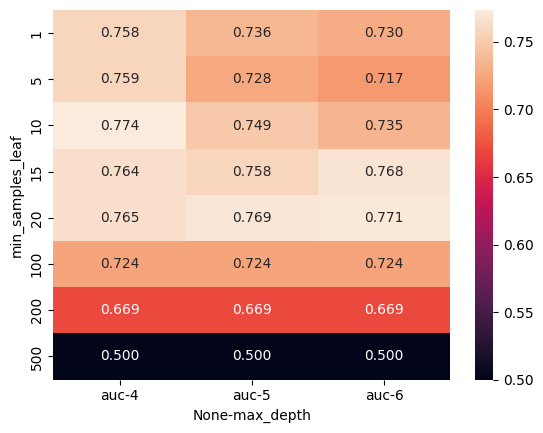

In [96]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=[
                                  'max_depth'], values=['auc'])
df_scores_pivot.round(3)
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")


In [97]:
# Chose least complex min_samples_leaf param with best auc
best_dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
best_dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

#### <b id="tuning-xgb">XGBoost</b>

<b>Tuning eta / Learning Rate Parameter</b>

In [98]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = float(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


In [99]:
import xgboost as xgb
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]


In [100]:
eta_scores = {}


In [101]:
%%capture output

xgb_params = {
    'eta': 1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [102]:
key = 'eta=%s' % (xgb_params['eta'])
eta_scores[key] = parse_xgb_output(output)


In [103]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [104]:
key = 'eta=%s' % (xgb_params['eta'])
eta_scores[key] = parse_xgb_output(output)


In [105]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [106]:
key = 'eta=%s' % (xgb_params['eta'])
eta_scores[key] = parse_xgb_output(output)


In [107]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [108]:
key = 'eta=%s' % (xgb_params['eta'])
eta_scores[key] = parse_xgb_output(output)


In [109]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [110]:
key = 'eta=%s' % (xgb_params['eta'])
eta_scores[key] = parse_xgb_output(output)


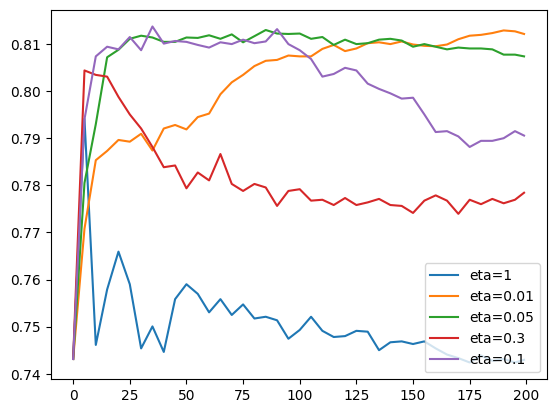

In [111]:
# Plot the xgb output for the eta values
for key, df_score in eta_scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()


The graph above shows us that the ideal value for the eta parameter is 0.01. As is reaches and maintains the highest auc score

<b>Tuning max depths parameter</b>

In [112]:
md_scores = {}


In [113]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 2,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [114]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
md_scores[key] = parse_xgb_output(output)


In [115]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [116]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
md_scores[key] = parse_xgb_output(output)


In [117]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [118]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
md_scores[key] = parse_xgb_output(output)


In [119]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [120]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
md_scores[key] = parse_xgb_output(output)


In [121]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [122]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
md_scores[key] = parse_xgb_output(output)


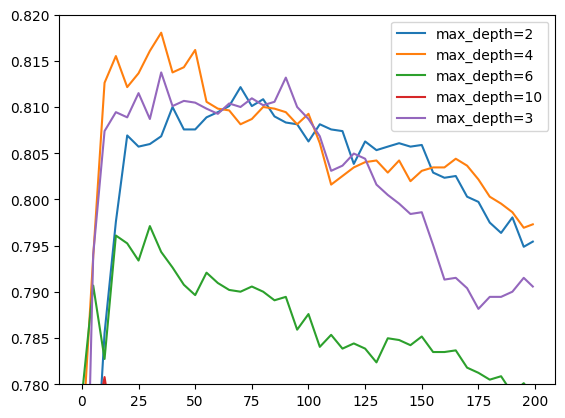

In [123]:
for max_depth, df_score in md_scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.ylim(0.78, 0.82)
plt.legend()


it looks as though the ideal value is 4, they all peak fairly quickly however 4 hits the highest value and maintains the best towards the latest iterations.

<b>Tuning Min child wieght</b>

In [124]:
mcw_scores = {}


In [125]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [126]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
mcw_scores[key] = parse_xgb_output(output)
key


'min_child_weight=30'

In [127]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [128]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
mcw_scores[key] = parse_xgb_output(output)
key


'min_child_weight=10'

In [129]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [130]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
mcw_scores[key] = parse_xgb_output(output)
key


'min_child_weight=1'

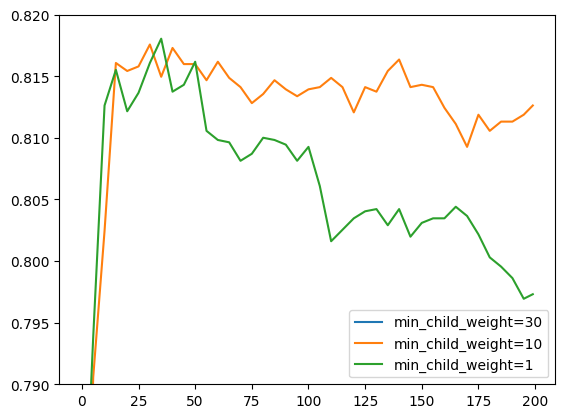

In [131]:
for min_child_weight, df_score in mcw_scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.ylim(0.79, 0.82)
plt.legend()


Although the difference here for the outcomes of various min child weight values does not look significant. It is evident that a min child weight of 10 yields the best auc score

<b>Tuned XGBoost Model</b>


In [132]:
best_xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

best_xgb_model = xgb.train(best_xgb_params, dtrain, num_boost_round=175)


### <u id="model-selection">Model Selection</u>

<b> Model Evaluation Helper Methods </b>

In [133]:
def generate_confusion_matrix(y_val, y_pred):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    t = 0.5
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    confusion_matrix = np.array([
        [tn, fp],
        [fn, tp]
    ])
    return confusion_matrix


def generate_confusion_table(confusion_matrix):
    return (confusion_matrix / confusion_matrix.sum()).round(4)


def precision_recall(confusion_matrix):
    # True positives over all reported positives
    precision = confusion_matrix[1][1] / \
        (confusion_matrix[1][1] + confusion_matrix[0][1])
    # True positives over actual positives
    recall = confusion_matrix[1][1] / \
        (confusion_matrix[1][1] + confusion_matrix[1][0])
    return ({'precision': precision, 'recall': recall})


def plot_roc_curve(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
    plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
    plt.legend()


def evaluate_model(pred, actual):
    confusion_matrix = generate_confusion_matrix(y_val=actual, y_pred=pred)
    confusion_table = generate_confusion_table(confusion_matrix)

    print("Confusion Table")
    print(confusion_table)
    print("\n")

    precision_recall_dict = precision_recall(confusion_matrix)

    print("Precision and Recall")
    print(precision_recall_dict)
    print("\n")

    print("ROC Curve")
    plot_roc_curve(y_val=actual, y_pred=pred)


<b>Evaluate Logistic Regression</b>

In [134]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, lr_y_pred)


0.8451790633608816

Confusion Table
[[0.5714 0.0714]
 [0.1494 0.2078]]


Precision and Recall
{'precision': 0.7441860465116279, 'recall': 0.5818181818181818}


ROC Curve


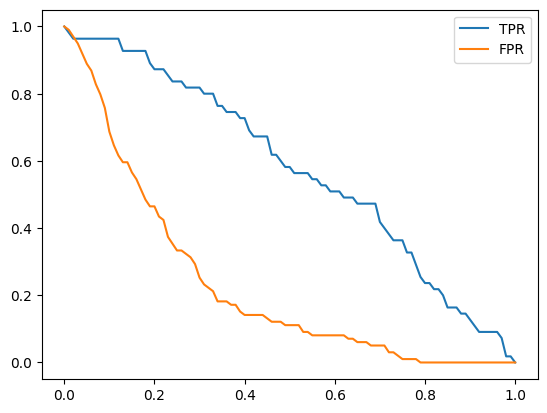

In [135]:
evaluate_model(pred=lr_y_pred, actual=y_test)


<b>Evaluate Decision Tree</b>

In [136]:
y_pred = best_dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)


0.8162534435261708

Confusion Table
[[0.5649 0.0779]
 [0.1104 0.2468]]


Precision and Recall
{'precision': 0.76, 'recall': 0.6909090909090909}


ROC Curve


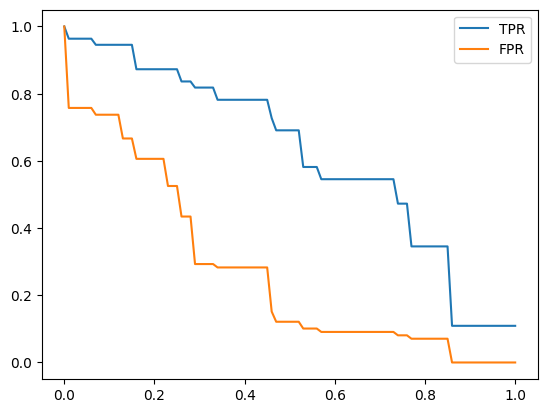

In [137]:
evaluate_model(pred=y_pred, actual=y_test)


<b>Evaluate XGBoost</b>

In [138]:
y_pred = best_xgb_model.predict(dtest)
roc_auc_score(y_test, y_pred)


0.8685032139577594

Confusion Table
[[0.5325 0.1104]
 [0.0909 0.2662]]


Precision and Recall
{'precision': 0.7068965517241379, 'recall': 0.7454545454545455}


ROC Curve


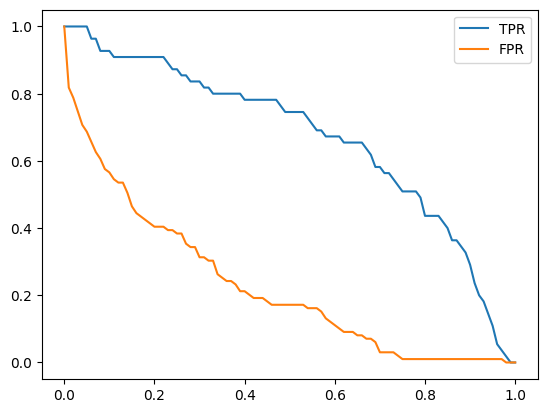

In [139]:
evaluate_model(pred=y_pred, actual=y_test)


It's evident from the above figues that xgboost has the best results. The confusion table shows it has the most true negative and true positives. This is also shown via the precision and recall values.

### <u id="final">Train Final Model</u>

In [140]:
y_full = df_full_train.outcome.values
df_full_train.drop(columns_to_drop, axis=1, inplace=True)


In [141]:
dicts_full_train = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)

X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.fit_transform(dicts_test)


In [142]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full)

dtest = xgb.DMatrix(X_test)

# X_test[0]
# X_full_train[0]


In [143]:
best_xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

best_xgb_model = xgb.train(best_xgb_params, dfulltrain, num_boost_round=175)


In [144]:
y_pred = best_xgb_model.predict(dtest)
y_pred


array([0.673073  , 0.05756766, 0.041271  , 0.36969367, 0.25005516,
       0.22664705, 0.35658568, 0.00949129, 0.30097076, 0.07025811,
       0.6454832 , 0.01361703, 0.73591125, 0.8246673 , 0.01066197,
       0.67126274, 0.38416737, 0.46138668, 0.00293864, 0.21659991,
       0.58884186, 0.62468755, 0.82884544, 0.08680339, 0.03547923,
       0.30539736, 0.37011844, 0.953953  , 0.29068717, 0.77097154,
       0.0742588 , 0.1724391 , 0.00744705, 0.9733059 , 0.4925017 ,
       0.8352916 , 0.03435115, 0.35347468, 0.05180527, 0.5158467 ,
       0.09321749, 0.06085304, 0.00909864, 0.77122724, 0.01774175,
       0.00312987, 0.8681044 , 0.9379617 , 0.00720346, 0.13142148,
       0.00365944, 0.3015322 , 0.95602095, 0.00301367, 0.88229525,
       0.09753571, 0.43957004, 0.26534295, 0.1288288 , 0.43180084,
       0.4517572 , 0.00448205, 0.8442769 , 0.07529293, 0.73759884,
       0.05163791, 0.09539789, 0.46707717, 0.87505764, 0.90562856,
       0.91745114, 0.8003804 , 0.49767378, 0.00183934, 0.44757

In [145]:
roc_auc_score(y_test, y_pred)


0.8453627180899908

### <u id="export">Export model via Bentoml</u>

In [146]:
import bentoml
bentoml.xgboost.save_model(
    "diabetes_risk_model", best_xgb_model, custom_objects={"dictVectorizer": dv})


Model(tag="diabetes_risk_model:sy2y7td7ngkdmkwq", path="/Users/tomthorne/bentoml/models/diabetes_risk_model/sy2y7td7ngkdmkwq/")

### <u id="test">Test JSON Example</u>

In [147]:

import json
test_data = df_test.iloc[1].to_dict()
print(json.dumps(test_data, indent=2))


{
  "pregnancies": 1.0,
  "glucose": 151.0,
  "bloodpressure": 60.0,
  "skinthickness": 0.0,
  "insulin": 0.0,
  "bmi": 26.1,
  "diabetespedigreefunction": 0.179,
  "age": 22.0
}
